# ___TRABAJO FINAL DE MÁSTER___
# ___Reto IBM___: Clasificación de imágenes de marcas
## Máster Universitario en Big Data Analytics - MBI
### Universidad Europea de Madrid
### ___Andrés Darío Gutiérrez Poveda___
#### Octubre 2021

# Descompresión de Datasets

In [ ]:
!unzip datasets.zip

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/AMD/
  inflating: datasets/AMD/AMD (1).jpg  
  inflating: datasets/AMD/AMD (10).jpg  
  inflating: datasets/AMD/AMD (11).jpg  
  inflating: datasets/AMD/AMD (12).jpg  
  inflating: datasets/AMD/AMD (13).jpg  
  inflating: datasets/AMD/AMD (14).jpg  
  inflating: datasets/AMD/AMD (15).jpg  
  inflating: datasets/AMD/AMD (16).jpg  
  inflating: datasets/AMD/AMD (17).jpg  
  inflating: datasets/AMD/AMD (18).jpg  
  inflating: datasets/AMD/AMD (19).jpg  
  inflating: datasets/AMD/AMD (2).jpg  
  inflating: datasets/AMD/AMD (20).jpg  
  inflating: datasets/AMD/AMD (21).jpg  
  inflating: datasets/AMD/AMD (22).jpg  
  inflating: datasets/AMD/AMD (23).jpg  
  inflating: datasets/AMD/AMD (24).jpg  
  inflating: datasets/AMD/AMD (25).jpg  
  inflating: datasets/AMD/AMD (26).jpg  
  inflating: datasets/AMD/AMD (27).jpg  
  inflating: datasets/AMD/AMD (28).jpg  
  inflating: datasets/AMD/AMD (29).jpg  
  inflating: datasets/AMD/A

# Importación de librerias



In [ ]:
# Se importa todas las liberias a utilizar en el proyecto.
import os, signal
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import keras
import random
import time
import shutil
import matplotlib.pyplot as plt
from numpy import expand_dims
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Reinicio de la sesión.
tf.keras.backend.clear_session()
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resNet50
from tensorflow.keras.optimizers import Adam

# API Keras
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet, vgg16, inception_v3
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from keras.applications.inception_v3 import preprocess_input as preprocess_inceptionV3
from keras.models import Model

## Funciones

In [ ]:
"""
Created on Mon Jul 31 20:05:23 2017
@author: DIP
@Copyright: Dipanjan Sarkar
"""

from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
    
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Tratamiento del dataset

## Carga del dataset

Se va a utilizar la transferencia de conocimiento para la clasificación de un dataset de imágenes de marcas que consta de 23 categorías entregadas en dos dataset:

___Dataset Público___
1. AMD
2. Aquafina
3. Disney
4. D-Link
5. Domino's Pizza
6. Hellmann's
7. IBM
8. Kitkat
9. LG
10. Lipton
11. McDonalds
12. Milka
13. Monster
14. Nestea
15. Pac-Man
16. Pepsi
17. Pizza Hut
18. Red Bull
19. Samsung
20. Sony
21. Tic Tac
22. Universal

___Dataset Individual___
23. Heineken

A continuación se carga el dataset y se comprueba que contiene información para poder cumplir con el objetivo del reto:

In [ ]:
# Se define el directorio donde se encuentran las imagenes con las que se ejecuta el modelo
dirPath = "datasets/"

# Se valida que el directorio exista:
if (os.path.isdir(dirPath)):
    # Se define la lista de categorias que contiene el diectorio
    categoriasDir = os.listdir(dirPath)
    for categoria in categoriasDir:
        print("Categoría: '" + categoria + "' contiene '" + str(len([item for item in os.listdir(dirPath + categoria) 
             if os.path.isfile(os.path.join(dirPath + categoria, item))]))+ "' imagenes.")
else:
    print("No existe el directorio en la ruta especificada...")

Categoría: 'Domino's Pizza' contiene '70' imagenes.
Categoría: 'IBM' contiene '71' imagenes.
Categoría: 'Pizza Hut' contiene '70' imagenes.
Categoría: 'Aquafina' contiene '70' imagenes.
Categoría: 'McDonalds' contiene '70' imagenes.
Categoría: 'Monster' contiene '70' imagenes.
Categoría: 'samsung' contiene '70' imagenes.
Categoría: 'Universal' contiene '70' imagenes.
Categoría: 'LG' contiene '70' imagenes.
Categoría: 'D-link' contiene '70' imagenes.
Categoría: 'Hellmann's' contiene '70' imagenes.
Categoría: 'Pepsi' contiene '70' imagenes.
Categoría: 'Tic Tac' contiene '70' imagenes.
Categoría: 'Kitkat' contiene '70' imagenes.
Categoría: 'PacMan' contiene '70' imagenes.
Categoría: 'Nestea' contiene '70' imagenes.
Categoría: 'Lipton' contiene '70' imagenes.
Categoría: 'Disney' contiene '70' imagenes.
Categoría: 'Red Bull' contiene '70' imagenes.
Categoría: 'sony' contiene '70' imagenes.
Categoría: 'AMD' contiene '70' imagenes.
Categoría: 'Milka' contiene '70' imagenes.
Categoría: 'Heinek

Se encuentra que las diferentes categorías se encuentran balanceadas, cada uno tiene 70 imágenes, por lo que la clasificación no va a estar inclinada hacia alguna categoría en especial.

In [ ]:
# Se genera un número aletorio teniendo en cuenta el total de número de imagenes
numAleatorio = random.randint(1, 70)
aleatorio = str(numAleatorio)

# Se hace una carga de una imagen mediante 'load_img' para verificar que se vizualizan desde su categoría
for categoria in categoriasDir:    
    image.load_img(dirPath + categoria + '/' + categoria + ' (' + aleatorio + ').jpg')

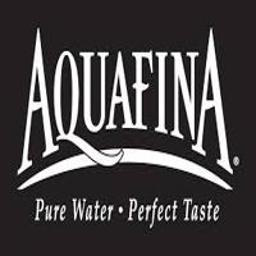

In [ ]:
# Se hace una carga de una imagen mediante 'load_img' para verificar que se vizualizan desde su categoría
image.load_img(dirPath + categoriasDir[3] + '/' + categoriasDir[3] + ' (' + aleatorio + ').jpg')

## Definición de dataset para Train, Validation y Evaluation

A continuación creamos nuestro <font color=blue>ImageDataGenerator</font> para los datos del directorio de __marcas__:

El *'ImageDataGenerator'* hace ciertas transformaciones definiendole sus parámetros, tales como, una función de preprocesado, que es especial para cada una de las redes, tamaño predeterminado, o rgb por vgr, ect.. 

El *'ImageDataGenerator'* se está creando con un __57%__ para datos de __Training__, __21,5%__ para nuestros datos de __Validation__ y __21,5%__ para nuestros datos de __Evaluation__.

In [ ]:
train_set = np.array([])
validation_set = np.array([])
evaluation_set = np.array([])

for categoria in categoriasDir:
    cat_files = glob.glob(dirPath + categoria + '/*')
    train_cat = np.random.choice(cat_files, size=40, replace=False)
    cat_files = list(set(cat_files) - set(train_cat))
    validation_cat = np.random.choice(cat_files, size=15, replace=False)
    cat_files = list(set(cat_files) - set(validation_cat))
    evaluation_cat = np.random.choice(cat_files, size=15, replace=False)
    train_set = np.append(train_set, train_cat)
    validation_set = np.append(validation_set, validation_cat)
    evaluation_set = np.append(evaluation_set, evaluation_cat)

print('Datasets:', train_set.shape, validation_set.shape, evaluation_set.shape)

Datasets: (920,) (345,) (345,)


In [ ]:
train_dir = '01_training_data/'
valid_dir = '02_validation_data/'
evalu_dir = '03_evaluation_data/'
evaluation_labels = np.array([])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(valid_dir) if not os.path.isdir(valid_dir) else None
os.mkdir(evalu_dir) if not os.path.isdir(evalu_dir) else None

for fn in train_set:
    clase = fn.split('/')[1].split('(')[0].strip()
    os.mkdir(train_dir + clase) if not os.path.isdir(train_dir + clase) else None
    shutil.copy(fn, train_dir + clase + "/")

for fn in validation_set:
    clase = fn.split('/')[1].split('(')[0].strip()
    os.mkdir(valid_dir + clase) if not os.path.isdir(valid_dir + clase) else None
    shutil.copy(fn, valid_dir + clase + "/")
    
for fn in evaluation_set:
    clase = fn.split('/')[1].split('(')[0].strip()
    evaluation_labels = np.append(evaluation_labels,clase)
    os.mkdir(evalu_dir + clase) if not os.path.isdir(evalu_dir + clase) else None
    shutil.copy(fn, evalu_dir + clase + "/")

In [ ]:
# Se define ImageDataGenerator
image_datagenVGG16 = ImageDataGenerator(preprocessing_function = preprocess_vgg16)

# Se define el train_generator tomando los datos desde un directorio (flow_from_directory)
# y con sus respectivos parametros, tamaño, tipo de color, ect...
train_generatorVGG16 = image_datagenVGG16.flow_from_directory(train_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 2,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el validation_generator.
validation_generatorVGG16 = image_datagenVGG16.flow_from_directory(valid_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 2,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el evaluation_generator.
evaluation_generatorVGG16 = image_datagenVGG16.flow_from_directory(evalu_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 2,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

Found 920 images belonging to 23 classes.
Found 345 images belonging to 23 classes.
Found 345 images belonging to 23 classes.


In [ ]:
print("Lo anterior quiere decir que vamos a entrenar nuestro modelo con: \n"
      + "Datos: " + str(train_generatorVGG16.subset) + "\nImagenes: " + str(len(train_generatorVGG16.filepaths)) 
                        + "\nClases: " + str(train_generatorVGG16.num_classes))

print("\nDatos: " + str(validation_generatorVGG16.subset) 
      + "\nImagenes: " + str(len(validation_generatorVGG16.filepaths)) 
      + "\nClases: " + str(validation_generatorVGG16.num_classes))

print("\nDatos: " + str(evaluation_generatorVGG16.subset) 
      + "\nImagenes: " + str(len(evaluation_generatorVGG16.filepaths)) 
      + "\nClases: " + str(evaluation_generatorVGG16.num_classes))

Lo anterior quiere decir que vamos a entrenar nuestro modelo con: 
Datos: training
Imagenes: 920
Clases: 23

Datos: training
Imagenes: 345
Clases: 23

Datos: training
Imagenes: 345
Clases: 23


# Modelos de clasificación de imágenes

El esquema de modelos de clasificación de imágenes tiene capas convolucionales seguidas de capas completamente conectadas. Las capas de convolución extraen las características (*features*) de la imagen  y las capas completamente conectadas (*fully conected*) realizan la clasificación la imagen usando estás características extraídas.

Cuando se entrena una CNN con un dataset de imágenes, se ve que las capas superiores de la red aprenden a extraer características generales de imágenes como bordes, distribución de colores, etc. A medida que se avanza en la red, las capas tienden a extraer más características específicas y de está manera va realizando el aprendizaje.

Ahora se puede usar estos modelos previamente entrenados que ya saben cómo extraer las características y evitar el entrenamiento desde cero. Este concepto se conoce como “Transfer Learning”. Lo anterior quiere decir, que se puede aprovechar al máximo el conocimiento de modelos potentes con el fin de extraer sus características. 
Por ejemplo, si se quiere clasificar una imagen se puede emplear un modelo preentrenado con ‘imagenet’, que cuenta con una gran colección de datos de imágenes (contiene 1000 categorías) y así  clasificar cualquier imagen que se encuentre dentro de las mismas.

En consecuencia, se a aprovechará las diferentes arquitecturas de redes CNN, para extraer sus características y reentrenar los modelos. Definiendo capas propias, clasificadores propios, números de iteraciones propios, etc., con el fin de evaluar estos modelos construidos para la clasificación en las 23 categorías listadas anteriormente.

# Construcción y entrenamiento de modelos

## Modelo 1: __VGG16 BÁSICO__

### Construcción del modelo:

Se va a constuir un modelo preentrenado con la red ***`VGG16`*** sin la última capa, con los pesos de _imagenet_.

In [ ]:
# Se define el modelo BASE
base_modelVGG16 = vgg16.VGG16(weights = 'imagenet', include_top = False) 
# La API funcional de Keras
x = base_modelVGG16.output
# Se agrega una capa AveragePooling
x = GlobalAveragePooling2D()(x)
# Se agrega una capa densa con 512 y activado con RELU
x = Dense(512, activation = 'relu')(x)
# Por último, se agrega una capa densa con el número de categorias que queremos predecir, en ese caso 23.
predsX = Dense(23, activation = 'softmax')(x)

58900480/58889256 [==============================] - 0s 0us/step


<p align="justify">
Al definir la arquitectura del <font color=Blue>modelo Vgg16 </font> anterior se ve que se tiene en cuenta los pesos entrenados de imagenet, pero que no incluya la últma capa, ya que queremos es utilizar todo el conocimiento de la red VGG16 enviandole nuestro propio directorio de imagenes.
    
Adicional se agregan una capa *'AveragePooling'* para reducir el tamaño de la imagen y una capa *'densa'* con sus respectivas unidades para que tenga conectividad completa entre las neuronas.
Por último, se agrega una capa '*densa*' con el número de categorias que queremos predecir, en ese caso 23.
    
Se tiene en cuenta el tipo de activaciones *'Relu'* que solo se activa con números positivos, se comporta bien con imágenes y su desempeño en redes convolucionales es bueno.

Se utiliza *'Softmax'*, que es una función de activación que transforma las salidas a una representación en forma de probabilidades, es muy diferenciable y tiene buen rendimiento en las últimas capas.

<p>

In [ ]:
# Se define el modelo con el input el modelo base y su respectivo ouput:
modelVGG16 = Model(inputs = base_modelVGG16.input, outputs = predsX)
# Se imprime el resumen del modelo
modelVGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Se evidencia que el ___total de parámetros es alrededor de 15 millones___, siendo estos un buen número de parametros para nuestro modelo.

Se realiza el <font color=blue>conteo de las capas del modelo base y del modelo,</font> con el fin de poder congelar dichas capas y realizar el entrenamiento.

In [ ]:
#Se cuenta cuantas capas tiene mi modelo base:
print("Las capas que tiene mi 'modelo base' son: " + str(len(base_modelVGG16.layers)) + "\n")

#Se cuenta cuantas capas tiene el modelo:
print("Las capas que tiene mi 'modelo' son: " + str(len(modelVGG16.layers)))

Las capas que tiene mi 'modelo base' son: 19

Las capas que tiene mi 'modelo' son: 22


Las capas del modelo son las del 'modelo base' más las que se agreganron en la arquitectura: *global_average_pooling2d_1, dense_1 y dense_2*.

Se define teniendo en cuenta la capa del modelo base, cuales son las capas de mi modelo con las que se va a entrenar, ya que necesitamos que el modelo solamente aprenda a partir de dicha capa que definamos, debido a que si le decimos que lo realice desde antes o desde la capa cero le va a costar mucho más.

In [ ]:
# Se 'congela' las capas del modelo de la siguiente manera:
for layer in modelVGG16.layers[:19]:
    layer.trainable = False
for layer in modelVGG16.layers[19:]:
    layer.trainable = True

<font color=blue>Congelar las capas</font> significa mantener los pesos que tenga independientemente del entrenamiento que se realice. Lo que se está haciendo aquí es decirle que solamente actualice estos parámetros, no todos, porque lo que se quiere es que se adapte a nuestras características.

Se realiza <font color=blue>la compilación del modelo</font> en dónde se se inicializan las variables para realizar el *'BackPropagation'* con un optimizador y una función de coste, utilizando:<br>

- Optimizer: 'Adam'
- Loss: 'Categorical cross entropy'
- Metrics: 'accuracy' y 'mse'

In [ ]:
# Se complila el modelo
modelVGG16.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Se realiza el cálculo del número total de pasos
step_size_trainVGG16 = (train_generatorVGG16.n // train_generatorVGG16.batch_size)

### Entrenamiento del modelo (5 epochs)

Se realiza el **entrenamiento del modelo(fit)** con su compilador, número de pasos y <font color=green> 5 epochs.</font> Es decir, las iteraciones(*epochs*) que va a realizar el modelo sobre todos los datos.

In [ ]:
# Se definine un contador de tiempo para validar cuando tarda en entrenar el modelo
tic = time.perf_counter()

# Se entrena el modelo el número de iteraciones (epoch) a 5
history = modelVGG16.fit_generator(generator = train_generatorVGG16, 
                         steps_per_epoch = step_size_trainVGG16,
                         epochs = 5, 
                         validation_data = validation_generatorVGG16)

# Se define el contador una vez termina de entrenar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo el modelo
print(f"\nEntrenando el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
460/460 [==============================] - 753s 2s/step - loss: 3.6334 - accuracy: 0.3984 - mse: 0.0364 - val_loss: 1.1757 - val_accuracy: 0.7362 - val_mse: 0.0169
Epoch 2/5
460/460 [==============================] - 737s 2s/step - loss: 0.4466 - accuracy: 0.8488 - mse: 0.0087 - val_loss: 1.3308 - val_accuracy: 0.7536 - val_mse: 0.0157
Epoch 3/5
460/460 [==============================] - 738s 2s/step - loss: 0.3579 - accuracy: 0.9397 - mse: 0.0041 - val_loss: 1.2279 - val_accuracy: 0.7391 - val_mse: 0.0160
Epoch 4/5
460/460 [==============================] - 738s 2s/step - loss: 0.0705 - accuracy: 0.9809 - mse: 0.0013 - val_loss: 1.9730 - val_accuracy: 0.6812 - val_mse: 0.0212
Epoch 5/5
460/460 [==============================] - 738s 2s/step - loss: 0.1607 - accuracy: 0.9521 - mse: 0.0032 - val_loss: 1.8926 - val_accuracy: 0.7101 - val_mse: 0.0197

Entrenando el modelo tarda alrededor de: 61.9977 minutos


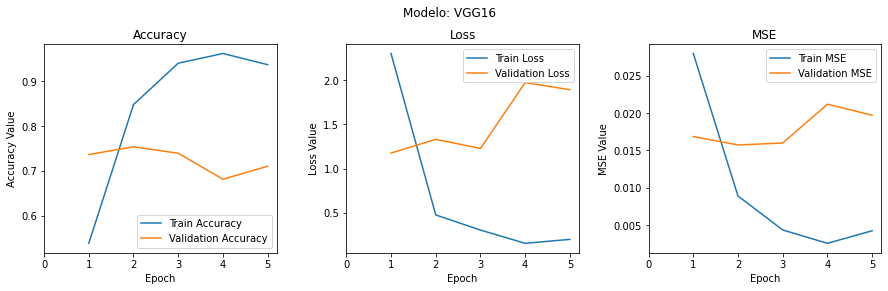

In [ ]:
# Definición para graficar resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Modelo: VGG16', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,6))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 6, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 6, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history.history['mse'], label='Train MSE')
ax3.plot(epoch_list, history.history['val_mse'], label='Validation MSE')
ax3.set_xticks(np.arange(0, 6, 1))
ax3.set_ylabel('MSE Value')
ax3.set_xlabel('Epoch')
ax3.set_title('MSE')
l3 = ax3.legend(loc="best")

### Evaluación del modelo:

<font color=blue> Se construye</font> una función para evaluar el modelo con imagenes del dataset de evaluación..

In [ ]:
# Se define el directorio para saber las categorias dentro de 'train_generator'
class_dict = {v:k for k, v in train_generatorVGG16.class_indices.items()}

# Se define la función para predecir la imagen dando la ruta del archivo
def predict_imageVGG16(path,retornar):
    img = image.load_img(path) # Se carga la imagen.
    img = img.resize((256, 256)) # Tamaño de la imagen, por temas de memoria y quepa bien puesta.
    data = expand_dims(image.img_to_array(img), 0) # Se añade un 4Tensor.
    data = preprocess_vgg16(data) # Se realiza el preprocesado para VGG16.
    preds = modelVGG16.predict(data) # Modelado VGG16 definido anteriormente.
    pred = np.argmax(preds) # Predicción de la imagen con la ultima capa 'preds'.
    pred = class_dict[pred] # Categoria a la que pertenece.
    if retornar:
        print(pred) # impime la categoria
        return img # retorna la imagen de la ruta enviada como parametro.
    else:
        return pred

AMD


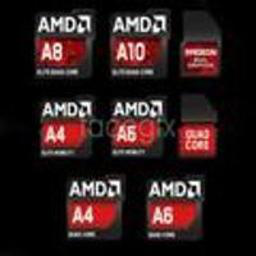

In [ ]:
# Ahora se prueba la función con las imágenes de evaluación:
# Se define la ruta donde se encuentran las imágenes de ADM de evaluación.
path  = "03_evaluation_data/AMD/"
predict_imageVGG16(path + 'AMD (52).jpg',1)

PacMan


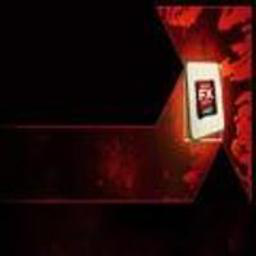

In [ ]:
predict_imageVGG16(path + 'AMD (55).jpg',1)

Aquafina


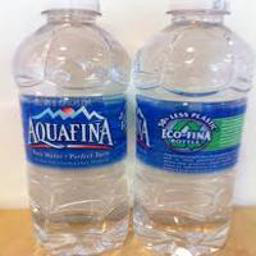

In [ ]:
# Se define la ruta donde se encuentran las imágenes de Aquafina de evaluación.
path  = "03_evaluation_data/Aquafina/"
predict_imageVGG16(path + 'Aquafina (21).jpg',1)

Red Bull


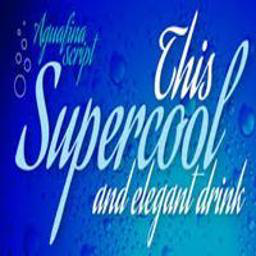

In [ ]:
predict_imageVGG16(path + 'Aquafina (54).jpg',1)

In [ ]:
path  = "03_evaluation_data/"
true_labels = np.array([])
pred_labels = np.array([])

#Se definine un contador de tiempo para validar cuando tarda en evaluar el modelo
tic = time.perf_counter()

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            true_labels = np.append(true_labels,dirpath.split('/')[1].strip())
            pred_labels = np.append(pred_labels,predict_imageVGG16(new_path,0))

# Se define el contador una vez termina de evaluar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo la evaluación
print(f"\nEvaluar el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")


Evaluar el modelo tarda alrededor de: 3.8980 minutos


In [ ]:
# Evaluación del modelo VGG16 BÁSICO, incluyendo:
#    Reporte de desempeño
#    Reporte de clasificación del modelo
#    Reporte de matriz de confusión
display_model_performance_metrics(true_labels=true_labels, 
                                  predicted_labels=pred_labels, 
                                  classes=list(set(true_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.6928
Precision: 0.7558
Recall: 0.6928
F1 Score: 0.6845

Model Classification report:
------------------------------
                precision    recall  f1-score   support

         Milka       0.92      0.80      0.86        15
       samsung       0.88      0.47      0.61        15
        Kitkat       0.91      0.67      0.77        15
        Disney       1.00      0.07      0.12        15
            LG       0.89      0.53      0.67        15
      Heineken       0.45      0.67      0.54        15
       Tic Tac       0.92      0.80      0.86        15
      Aquafina       0.61      0.73      0.67        15
     McDonalds       0.90      0.60      0.72        15
     Universal       0.50      0.87      0.63        15
        Nestea       0.64      0.93      0.76        15
        Lipton       0.90      0.60      0.72        15
          sony       0.50      0.67      0.57        15
    Hellmann's       0.88    

Realizando la <font color=green>__EVALUACIÓN__</font> para este modelo <font color=red>__VGG16 BÁSICO__</font> con las imágenes dedicadas, se evidencia un __*accuracy*__ del __69,28%__ y un __*F-Score*__ del __68,45%__. Las clase que mejor de predijeron fueron Domino's Pizza con el un __*F-Score*__ de __0,97__ y Hellmann's con __0,90__; mientras que Disney tiene __0,12__ y Red Bull el __0,51__.

In [ ]:
# Se guarda el modelo
modelVGG16.save('VGG16_BASICO.h5')

### <font color=green>En los siguientes apartados se modificarán y probarán diferentes arquitecturas de redes CNN, con la finalidad de afinar diferentes parámetros y validar sus resultados, pero teniendo en cuenta lo visto y explicado anteriormente. Para este proyecto se entrenaron las siguientes arquitecturas: </font>

- VGG16
- MobileNet
- InceptionV3
- ResNet50


## Modelo 2: __VGG16 MODIFICADO__

### Modificación del modelo:

Se modifica la arquitectura del modelo ___VGG16___ entrenado anteriormente.

Los cambios a realizar:
- Se agregan capas densas con sus unidades de 1024, 512, 256. 
- Cambiando el 'batch_size' a 10
- Cambiando el optimizer = 'rmsprop'
- Cambiando el epochs= 8

In [ ]:
# Se define el modelo BASE
base_modelVGG16_1 = vgg16.VGG16(weights = 'imagenet', include_top = False)
# La API funcional de Keras
y = base_modelVGG16_1.output
# Se agrega una capa AveragePooling
y = GlobalAveragePooling2D()(y)
# Se agrega otra capa densa con 1024 
y = Dense(1024, activation = 'relu')(y)
# Se agrega otra capa densa con 512 
y = Dense(512, activation = 'relu')(y)
# Se agrega otra capa densa con 256 
y = Dense(256, activation = 'relu')(y)
# Por último, se agrega una capa densa con el número de categorias que queremos predecir, en ese caso 23.
predsY = Dense(23, activation = 'softmax')(y)

In [ ]:
# Se define el modelo con el input el modelo base y su respectivo ouput:
modelVGG16_1 = Model(inputs = base_modelVGG16_1.input, outputs = predsY)
# Se imprime el resumen del modelo
modelVGG16_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# Se cuenta cuantas capas tiene mi modelo base:
print("Las capas que tiene mi 'modelo base' son: " + str(len(base_modelVGG16_1.layers)) + "\n")

# Se cuenta cuantas capas tiene el modelo:
print("Las capas que tiene mi 'modelo' son: " + str(len(modelVGG16_1.layers)))

Las capas que tiene mi 'modelo base' son: 19

Las capas que tiene mi 'modelo' son: 24


In [ ]:
# Se 'congela' las capas del modelo de la siguiente manera:
for layer in modelVGG16_1.layers[:19]:
    layer.trainable = False
for layer in modelVGG16_1.layers[19:]:
    layer.trainable = True

In [ ]:
# Se define ImageDataGenerator
image_datagenVGG16_1 = ImageDataGenerator(preprocessing_function = preprocess_vgg16)

# Se define el train_generator tomando los datos desde un directorio (flow_from_directory)
# y con sus respectivos parametros, tamaño, tipo de color, ect...
train_generatorVGG16_1 = image_datagenVGG16_1.flow_from_directory(train_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 10,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el validation_generator.
validation_generatorVGG16_1 = image_datagenVGG16_1.flow_from_directory(valid_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 10,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el evaluation_generator.
evaluation_generatorVGG16_1 = image_datagenVGG16_1.flow_from_directory(evalu_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 10,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

Found 920 images belonging to 23 classes.
Found 345 images belonging to 23 classes.
Found 345 images belonging to 23 classes.


In [ ]:
print("Lo anterior quiere decir que vamos a entrenar nuestro modelo con: \n"
      + "Datos: " + str(train_generatorVGG16_1.subset) + "\nImagenes: " + str(len(train_generatorVGG16_1.filepaths)) 
      + "\nClases: " + str(train_generatorVGG16_1.num_classes))

print("\nDatos: " + str(validation_generatorVGG16_1.subset) 
      + "\nImagenes: " + str(len(validation_generatorVGG16_1.filepaths)) 
      + "\nClases: " + str(validation_generatorVGG16_1.num_classes))

print("\nDatos: " + str(evaluation_generatorVGG16_1.subset) 
      + "\nImagenes: " + str(len(evaluation_generatorVGG16_1.filepaths)) 
      + "\nClases: " + str(evaluation_generatorVGG16_1.num_classes))

Lo anterior quiere decir que vamos a entrenar nuestro modelo con: 
Datos: training
Imagenes: 920
Clases: 23

Datos: training
Imagenes: 345
Clases: 23

Datos: training
Imagenes: 345
Clases: 23


### Entrenamiento del modelo:

In [ ]:
# Se complila el modelo
modelVGG16_1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Se realiza el cálculo del número total de pasos
step_size_train_1 = (train_generatorVGG16_1.n // train_generatorVGG16_1.batch_size)

# Se definine un contador de tiempo para validar cuando tarda en entrenar el modelo
tic = time.perf_counter()

# Se entrena el modelo el número de iteraciones correspondientes
history_2 = modelVGG16_1.fit_generator(generator = train_generatorVGG16_1, 
                         steps_per_epoch = step_size_train_1,
                         epochs = 8, 
                         validation_data = validation_generatorVGG16_1)

# Se define el contador una vez termina de entrenar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo el modelo
print(f"Entrenando el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
92/92 [==============================] - 731s 8s/step - loss: 1.9165 - accuracy: 0.4767 - mse: 0.0291 - val_loss: 1.1914 - val_accuracy: 0.6783 - val_mse: 0.0186
Epoch 2/8
92/92 [==============================] - 728s 8s/step - loss: 0.6059 - accuracy: 0.8183 - mse: 0.0110 - val_loss: 1.0484 - val_accuracy: 0.7449 - val_mse: 0.0157
Epoch 3/8
92/92 [==============================] - 728s 8s/step - loss: 0.3343 - accuracy: 0.9039 - mse: 0.0063 - val_loss: 1.3080 - val_accuracy: 0.7478 - val_mse: 0.0168
Epoch 4/8
92/92 [==============================] - 729s 8s/step - loss: 0.1598 - accuracy: 0.9546 - mse: 0.0030 - val_loss: 1.5448 - val_accuracy: 0.7855 - val_mse: 0.0151
Epoch 5/8
92/92 [==============================] - 728s 8s/step - loss: 0.1126 - accuracy: 0.9664 - mse: 0.0022 - val_loss: 1.9118 - val_accuracy: 0.7333 - val_mse: 0.0193
Epoch 6/8
92/92 [==============================] - 728s 8s/step - loss: 0.1722 - accuracy: 0.9578 - mse: 0.0027 - val_loss: 2.2860 - val_acc

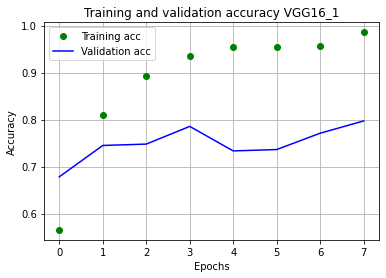

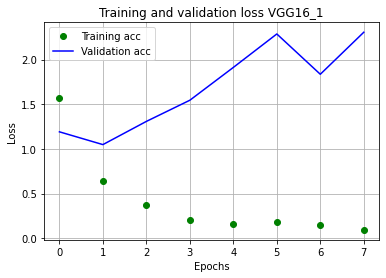

In [ ]:
# Definición para graficar resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Modelo: VGG16', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,9))
ax1.plot(epoch_list, history_2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history_2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 9, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 9, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history_2.history['mse'], label='Train MSE')
ax3.plot(epoch_list, history_2.history['val_mse'], label='Validation MSE')
ax3.set_xticks(np.arange(0, 9, 1))
ax3.set_ylabel('MSE Value')
ax3.set_xlabel('Epoch')
ax3.set_title('MSE')
l3 = ax3.legend(loc="best")

In [ ]:
# Se guarda los pesos y el modelo con extension '.h5'
modelVGG16_1.save_weights('weights_model_VGG16_1.h5')
modelVGG16.save('model_VGG16_1.h5')

### Evaluación del modelo:

In [ ]:
# Se define el directorio para saber las categorias
class_dict = {v:k for k, v in train_generatorVGG16_1.class_indices.items()}

# Se define la función para predecir la imagen dando la ruta del archivo
def predict_imageVGG16_1(path,retornar):
    img = image.load_img(path)#se carga la imagen.
    img = img.resize((256, 256))#tamaño de la imagen, por temas de memoria y quepa bien puesta.
    data = expand_dims(image.img_to_array(img), 0)#añadimos un 4Tensor.
    data = preprocess_vgg16(data)#realizamos el preprocesado para VGG16.
    preds = modelVGG16_1.predict(data)#modelado VGG16 definido anteriormente.
    pred = np.argmax(preds)#predicción de la imagen con la ultima capa 'preds'.
    pred = class_dict[pred]#categoria a la que pertenece.
    if retornar:
        print(pred)#impimir la categoria
        return img #retorna la imagen de la ruta enviada como parametro.
    else:
        return pred

AMD


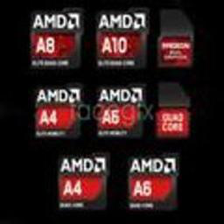

In [ ]:
# Ahora se prueba la función con las imágenes de evaluación:
# Se define la ruta donde se encuentran las imágenes de ADM de evaluación.
path  = "03_evaluation_data/AMD/"
predict_imageVGG16_1(path + 'AMD (52).jpg',1)

AMD


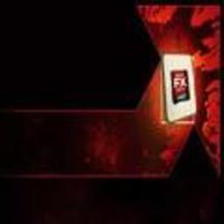

In [ ]:
predict_imageVGG16_1(path + 'AMD (55).jpg',1)

Aquafina


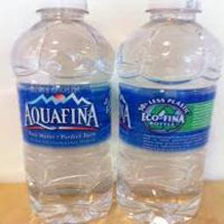

In [ ]:
# Se define la ruta donde se encuentran las imágenes de Aquafina de evaluación.
path  = "03_evaluation_data/Aquafina/"
predict_imageVGG16_1(path + 'Aquafina (21).jpg',1)

Milka


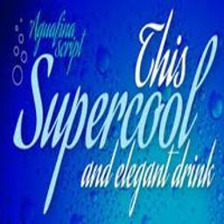

In [ ]:
predict_imageVGG16_1(path + 'Aquafina (54).jpg',1)

In [ ]:
path  = "03_evaluation_data/"
true_labels_1 = np.array([])
pred_labels_1 = np.array([])

# Se definine un contador de tiempo para validar cuando tarda en evaluar el modelo
tic = time.perf_counter()

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            true_labels_1 = np.append(true_labels_1,dirpath.split('/')[1].strip())
            pred_labels_1 = np.append(pred_labels_1,predict_imageVGG16_1(new_path,0))

# Se define el contador una vez termina de evaluar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo la evaluación
print(f"\nEvaluar el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")


Evaluar el modelo tarda alrededor de: 2.8829 minutos


In [ ]:
# Evaluación del modelo VGG16 BÁSICO, incluyendo:
#    Reporte de desempeño
#    Reporte de clasificación del modelo
#    Reporte de matriz de confusión
display_model_performance_metrics(true_labels=true_labels_1, 
                                  predicted_labels=pred_labels_1, 
                                  classes=list(set(true_labels_1)))

Model Performance metrics:
------------------------------
Accuracy: 0.7507
Precision: 0.7923
Recall: 0.7507
F1 Score: 0.7571

Model Classification report:
------------------------------
                precision    recall  f1-score   support

         Milka       0.35      0.87      0.50        15
       samsung       1.00      0.53      0.70        15
        Kitkat       0.81      0.87      0.84        15
        Disney       0.70      0.47      0.56        15
            LG       0.93      0.87      0.90        15
      Heineken       0.55      0.80      0.65        15
       Tic Tac       1.00      0.80      0.89        15
      Aquafina       0.60      0.80      0.69        15
     McDonalds       0.75      0.80      0.77        15
     Universal       0.83      0.67      0.74        15
        Nestea       0.93      0.93      0.93        15
        Lipton       0.79      0.73      0.76        15
          sony       0.67      0.67      0.67        15
    Hellmann's       0.93    

Realizando la <font color=green>__EVALUACIÓN__</font> para este modelo <font color=red>__VGG16 MODIFICADO__</font> con las imágenes dedicadas, se evidencia un __*accuracy*__ del __75,07%__ y un __*F-Score*__ del __75,71%__; una mejora con respecto al modelo básico de 6 puntos porcentuales. Las clase que mejor de predijeron fueron Domino's Pizza con el un __*F-Score*__ de __1.00__ y Nestea con __0.93__; mientras que Disney tiene __0,56__ y Milka el __0,50__.

In [ ]:
# Se guarda el modelo
modelVGG16.save('VGG16_MODIFICADO.h5')

## Modelo 3: __MobileNet__


### Construcción del modelo:

Se va a constuir un modelo preentrenado con la red  *__MobileNet__*.

In [ ]:
# Se define el modelo BASE y se descarta la última capa
base_modelMN = mobilenet.MobileNet(weights = 'imagenet', include_top = False) 
w = base_modelMN.output
# Se agrega una capa AveragePooling
w = GlobalAveragePooling2D()(w)
# Se agrega una capa densa con 1024 nodos y activado con RELU
w = Dense(1024, activation = 'relu')(w) 
# Se agrega una capa densa con 1024 nodos y activado con RELU
w = Dense(1024, activation = 'relu')(w)
# Se agrega una capa densa con 512 nodos y activado con RELU
w = Dense(512, activation = 'relu')(w)
# Por último, se agrega una capa densa con el número de categorias que queremos predecir, en ese caso 23.
predsW = Dense(23, activation = 'softmax')(w)

In [ ]:
# Se define el modelo con el input el modelo base y su respectivo ouput con preds:
modelMN = Model(inputs = base_modelMN.input, outputs = predsW)
# Se imprime el resumen del modelo
modelMN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0   

In [ ]:
# Se cuenta cuantas capas tiene mi modelo base:
print("Las capas que tiene mi 'modelo base' son: " + str(len(base_modelMN.layers)) + "\n")

# Se cuenta cuantas capas tiene el modelo:
print("Las capas que tiene mi 'modelo' son: " + str(len(modelMN.layers)))

Las capas que tiene mi 'modelo base' son: 86

Las capas que tiene mi 'modelo' son: 91


In [ ]:
# Se 'congela' las capas del modelo de la siguiente manera: tomamos las 20 últimas
for layer in modelMN.layers:
    layer.trainable = False
for layer in modelMN.layers[:87]:
    layer.trainable = False
for layer in modelMN.layers[87:]:
    layer.trainable = True

In [ ]:
# Se define ImageDataGenerator
image_datagenMN = ImageDataGenerator(preprocessing_function = preprocess_mobilenet)

# Se define el train_generator tomando los datos desde un directorio (flow_from_directory)
# y con sus respectivos parametros, tamaño, tipo de color, ect...
train_generatorMN = image_datagenMN.flow_from_directory(train_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 32, 
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

#Se define el validation_generator.
validation_generatorMN = image_datagenMN.flow_from_directory(valid_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el evaluation_generator.
evaluation_generatorMN = image_datagenMN.flow_from_directory(evalu_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 2,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

Found 920 images belonging to 23 classes.
Found 345 images belonging to 23 classes.
Found 345 images belonging to 23 classes.


In [ ]:
print("Lo anterior quiere decir que vamos a entrenar nuestro modelo con: \n"
      + "Datos: " + str(train_generatorMN.subset) 
      + "\nImagenes: " + str(len(train_generatorMN.filepaths)) 
      + "\nClases: " + str(train_generatorMN.num_classes))

print("\nDatos: " + str(validation_generatorMN.subset) 
      + "\nImagenes: " + str(len(validation_generatorMN.filepaths)) 
      + "\nClases: " + str(validation_generatorMN.num_classes))

print("\nDatos: " + str(evaluation_generatorMN.subset) 
      + "\nImagenes: " + str(len(evaluation_generatorMN.filepaths)) 
      + "\nClases: " + str(evaluation_generatorMN.num_classes))

Lo anterior quiere decir que vamos a entrenar nuestro modelo con: 
Datos: training
Imagenes: 920
Clases: 23

Datos: training
Imagenes: 345
Clases: 23

Datos: training
Imagenes: 345
Clases: 23


### Entrenamiento del modelo:

In [ ]:
# Se complila el modelo
modelMN.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Se realiza el cálculo del número total de pasos
step_size_trainMN = (train_generatorMN.n // train_generatorMN.batch_size)

In [ ]:
# Se definine un contador de tiempo para validar cuando tarda en entrenar el modelo
tic = time.perf_counter()

# Se entrena el modelo aumentando el númeo de iteraciones (epoch) a 12
history_3 = modelMN.fit_generator(generator = train_generatorMN, 
                          steps_per_epoch = step_size_trainMN,
                          epochs = 12, 
                          validation_data = validation_generatorMN)

# Se define el contador una vez termina de entrenar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo el modelo
print(f"Entrenando el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
28/28 [==============================] - 55s 2s/step - loss: 2.8804 - accuracy: 0.1851 - mse: 0.0402 - val_loss: 2.4804 - val_accuracy: 0.4348 - val_mse: 0.0372
Epoch 2/12
28/28 [==============================] - 48s 2s/step - loss: 2.2720 - accuracy: 0.5094 - mse: 0.0350 - val_loss: 1.9900 - val_accuracy: 0.4986 - val_mse: 0.0314
Epoch 3/12
28/28 [==============================] - 47s 2s/step - loss: 1.8092 - accuracy: 0.6286 - mse: 0.0293 - val_loss: 1.6455 - val_accuracy: 0.6174 - val_mse: 0.0268
Epoch 4/12
28/28 [==============================] - 47s 2s/step - loss: 1.3616 - accuracy: 0.7366 - mse: 0.0229 - val_loss: 1.3114 - val_accuracy: 0.7043 - val_mse: 0.0219
Epoch 5/12
28/28 [==============================] - 48s 2s/step - loss: 1.0997 - accuracy: 0.7938 - mse: 0.0187 - val_loss: 1.1967 - val_accuracy: 0.6957 - val_mse: 0.0199
Epoch 6/12
28/28 [==============================] - 48s 2s/step - loss: 0.8933 - accuracy: 0.8498 - mse: 0.0154 - val_loss: 1.0280 - val_acc

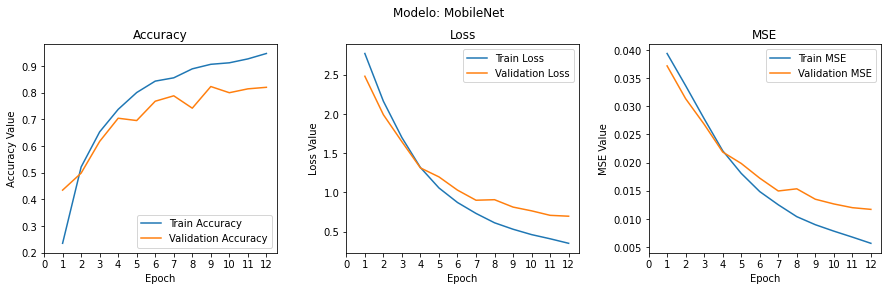

In [ ]:
# Definición para graficar resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Modelo: MobileNet', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,13))
ax1.plot(epoch_list, history_3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history_3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 13, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 13, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history_3.history['mse'], label='Train MSE')
ax3.plot(epoch_list, history_3.history['val_mse'], label='Validation MSE')
ax3.set_xticks(np.arange(0, 13, 1))
ax3.set_ylabel('MSE Value')
ax3.set_xlabel('Epoch')
ax3.set_title('MSE')
l3 = ax3.legend(loc="best")

### Evaluación del modelo:

In [ ]:
# Se define el directorio para saber las categorias dentro de 'train_generator'
class_dict = {v:k for k, v in train_generatorMN.class_indices.items()}

# Se define la función para predecir la imagen dando la ruta del archivo
def predict_imageMN(path,retornar):
    img = image.load_img(path)#se carga la imagen.
    img = img.resize((256, 256))#tamaño de la imagen, por temas de memoria y quepa bien puesta.
    data = expand_dims(image.img_to_array(img), 0)#añadimos un 4Tensor.
    data = preprocess_mobilenet(data)#realizamos el preprocesado para MobileNet.
    preds = modelMN.predict(data)#modelado MobileNet definido anteriormente.
    pred = np.argmax(preds)#predicción de la imagen con la ultima capa 'preds'.
    pred = class_dict[pred]#categoria a la que pertenece.
    if retornar:
        print(pred)#impimir la categoria
        return img #retorna la imagen de la ruta enviada como parametro.
    else:
        return pred

AMD


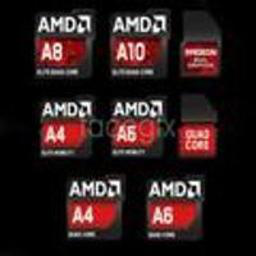

In [ ]:
# Ahora se prueba la función con las imágenes de evaluación:
# Se define la ruta donde se encuentran las imágenes de ADM de evaluación.
path  = "03_evaluation_data/AMD/"
predict_imageMN(path + 'AMD (52).jpg',1)

AMD


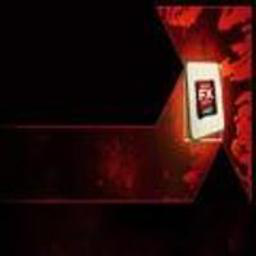

In [ ]:
predict_imageMN(path + 'AMD (55).jpg',1)

Aquafina


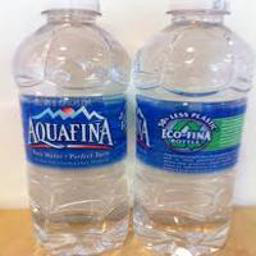

In [ ]:
# Se define la ruta donde se encuentran las imágenes de Aquafina de evaluación.
path  = "03_evaluation_data/Aquafina/"
predict_imageMN(path + 'Aquafina (21).jpg',1)

Disney


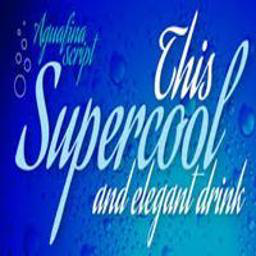

In [ ]:
predict_imageMN(path + 'Aquafina (54).jpg',1)

In [ ]:
path  = "03_evaluation_data/"
true_labels_3 = np.array([])
pred_labels_3 = np.array([])

# Se definine un contador de tiempo para validar cuando tarda en evaluar el modelo
tic = time.perf_counter()

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            true_labels_3 = np.append(true_labels_3,dirpath.split('/')[1].strip())
            pred_labels_3 = np.append(pred_labels_3,predict_imageMN(new_path,0))

# Se define el contador una vez termina de evaluar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo la evaluación
print(f"\nEvaluar el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")


Evaluar el modelo tarda alrededor de: 0.5353 minutos


In [ ]:
# Evaluación del modelo MobileNet, incluyendo:
#    Reporte de desempeño
#    Reporte de clasificación del modelo
#    Reporte de matriz de confusión
display_model_performance_metrics(true_labels=true_labels_3, 
                                  predicted_labels=pred_labels_3, 
                                  classes=list(set(true_labels_3)))

Model Performance metrics:
------------------------------
Accuracy: 0.8261
Precision: 0.846
Recall: 0.8261
F1 Score: 0.8281

Model Classification report:
------------------------------
                precision    recall  f1-score   support

         Milka       0.90      0.60      0.72        15
       samsung       0.90      0.60      0.72        15
        Kitkat       0.93      0.87      0.90        15
        Disney       0.71      0.67      0.69        15
            LG       0.88      1.00      0.94        15
      Heineken       0.73      0.73      0.73        15
       Tic Tac       1.00      0.73      0.85        15
      Aquafina       0.85      0.73      0.79        15
     McDonalds       0.88      0.93      0.90        15
     Universal       0.50      0.93      0.65        15
        Nestea       1.00      0.93      0.97        15
        Lipton       0.72      0.87      0.79        15
          sony       0.79      0.73      0.76        15
    Hellmann's       0.92     

Realizando la <font color=green>__EVALUACIÓN__</font> para este modelo <font color=red>__MobileNet__</font> con las imágenes dedicadas, se evidencia un __*accuracy*__ del __82,61%__ y un __*F-Score*__ del __82,81%__. Las clase que mejor de predijeron fueron Domino's Pizza con el un __*F-Score*__ de __100%__ y Nestea con __97%__; mientras que Red Bull tiene __58%__ y Universal el __65%__.

In [ ]:
# Se guarda el modelo
modelMN.save('MobileNet.h5')

## Modelo 4: __InceptionV3__

### Construcción del modelo:

Se va a constuir un modelo preentrenado con la red  *__InceptionV3__*.

In [ ]:
# Se define el modelo BASE y se descarga la última capa
base_modelIncV3 = inception_v3.InceptionV3(weights = 'imagenet', include_top = False) 
# La API funcional de Keras
z = base_modelIncV3.output
# Se agrega una capa AveragePooling -> una especie de normalización o regularización
z = GlobalAveragePooling2D()(z)
# Se agrega una capa densa con 1024 nodos y activado con RELU
z = Dense(512, activation = 'relu')(z)
# Se agrega una capa densa con 512 nodos y activado con RELU
z = Dense(128, activation = 'relu')(z)
# Por último, se agrega una capa densa con el número de categorias que queremos predecir, en ese caso 23.
predsZ = Dense(23, activation = 'softmax')(z)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Se define el modelo con el input el modelo base y su respectivo ouput con preds:
modelIncV3 = Model(inputs = base_modelIncV3.input, outputs = predsZ)
# Se imprime el resumen del modelo
modelIncV3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# Se cuenta cuantas capas tiene mi modelo base:
print("Las capas que tiene mi 'modelo base' son: " + str(len(base_modelIncV3.layers)) + "\n")

# Se cuenta cuantas capas tiene el modelo:
print("Las capas que tiene mi 'modelo' son: " + str(len(modelIncV3.layers)))

Las capas que tiene mi 'modelo base' son: 311

Las capas que tiene mi 'modelo' son: 315


In [ ]:
# Por el tipo de arquitectura de inception V3 no realizamos la congelación de las capas, se va a entrenar con todas:
for layer in base_modelIncV3.layers:
    layer.trainable = False

In [ ]:
# Se define ImageDataGenerator
image_datagenIncV3 = ImageDataGenerator(preprocessing_function = preprocess_inceptionV3)

# Se define el train_generator tomando los datos desde un directorio (flow_from_directory)
# y con sus respectivos parametros, tamaño, tipo de color, ect...
train_generatorIncV3 = image_datagenIncV3.flow_from_directory(train_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 64,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")
# Se define el validation_generator.
validation_generatorIncV3 = image_datagenIncV3.flow_from_directory(valid_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 64,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el evaluation_generator.
evaluation_generatorIncV3 = image_datagenIncV3.flow_from_directory(evalu_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 64,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

Found 920 images belonging to 23 classes.
Found 345 images belonging to 23 classes.
Found 345 images belonging to 23 classes.


In [ ]:
print("Lo anterior quiere decir que vamos a entrenar nuestro modelo con: \n"
      + "Datos: " + str(train_generatorIncV3.subset) 
      + "\nImagenes: " + str(len(train_generatorIncV3.filepaths)) 
      + "\nClases: " + str(train_generatorIncV3.num_classes))

print("\nDatos: " + str(validation_generatorIncV3.subset) 
      + "\nImagenes: " + str(len(validation_generatorIncV3.filepaths)) 
      + "\nClases: " + str(validation_generatorIncV3.num_classes))

print("\nDatos: " + str(evaluation_generatorIncV3.subset) 
      + "\nImagenes: " + str(len(evaluation_generatorIncV3.filepaths)) 
      + "\nClases: " + str(evaluation_generatorIncV3.num_classes))

Lo anterior quiere decir que vamos a entrenar nuestro modelo con: 
Datos: training
Imagenes: 920
Clases: 23

Datos: training
Imagenes: 345
Clases: 23

Datos: training
Imagenes: 345
Clases: 23


### Entrenamiento del modelo:

In [ ]:
# Se complila el modelo
modelIncV3.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Se realiza el cálculo del número total de pasos
step_size_trainIncV3 = (train_generatorIncV3.n // train_generatorIncV3.batch_size)

# Se definine un contador de tiempo para validar cuando tarda en entrenar el modelo
tic = time.perf_counter()

# Se entrena el modelo
history_4 = modelIncV3.fit_generator(generator = train_generatorIncV3, 
                          steps_per_epoch = step_size_trainIncV3,
                          epochs = 20, 
                          validation_data = validation_generatorIncV3)

# Se define el contador una vez termina de entrenar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo el modelo
print(f"\nEntrenando el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
14/14 [==============================] - 173s 11s/step - loss: 2.8712 - accuracy: 0.2185 - mse: 0.0388 - val_loss: 1.8645 - val_accuracy: 0.5130 - val_mse: 0.0289
Epoch 2/20
14/14 [==============================] - 145s 11s/step - loss: 1.4246 - accuracy: 0.6559 - mse: 0.0235 - val_loss: 1.3185 - val_accuracy: 0.6667 - val_mse: 0.0205
Epoch 3/20
14/14 [==============================] - 145s 11s/step - loss: 0.8061 - accuracy: 0.7811 - mse: 0.0143 - val_loss: 1.2590 - val_accuracy: 0.6609 - val_mse: 0.0193
Epoch 4/20
14/14 [==============================] - 145s 11s/step - loss: 0.5201 - accuracy: 0.8633 - mse: 0.0093 - val_loss: 0.9995 - val_accuracy: 0.7188 - val_mse: 0.0160
Epoch 5/20
14/14 [==============================] - 145s 11s/step - loss: 0.3161 - accuracy: 0.9385 - mse: 0.0051 - val_loss: 1.0089 - val_accuracy: 0.7420 - val_mse: 0.0153
Epoch 6/20
14/14 [==============================] - 145s 11s/step - loss: 0.2045 - accuracy: 0.9611 - mse: 0.0033 - val_loss: 1.00

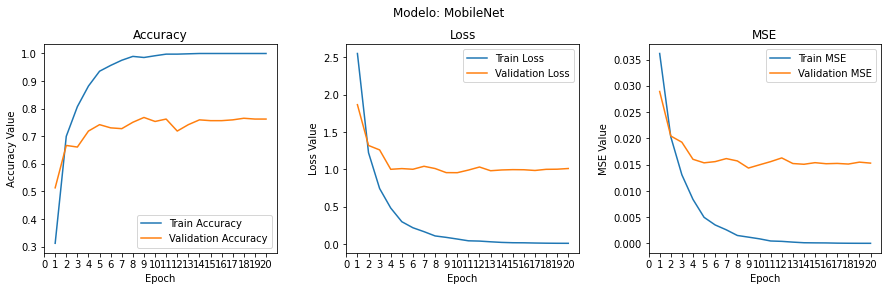

In [ ]:
# Definición para graficar resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Modelo: InceptionV3', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history_4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history_4.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history_4.history['mse'], label='Train MSE')
ax3.plot(epoch_list, history_4.history['val_mse'], label='Validation MSE')
ax3.set_xticks(np.arange(0, 21, 1))
ax3.set_ylabel('MSE Value')
ax3.set_xlabel('Epoch')
ax3.set_title('MSE')
l3 = ax3.legend(loc="best")

### Evaluación del modelo:

In [ ]:
# Se define el directorio para saber las categorias dentro de 'train_generator'
class_dict = {v:k for k, v in train_generatorIncV3.class_indices.items()}

# Se define la función para predecir la imagen dando la ruta del archivo
def predict_imageIncV3(path,retornar):
    img = image.load_img(path)#se carga la imagen.
    img = img.resize((256, 256))#tamaño de la imagen, por temas de memoria y quepa bien puesta.
    data = expand_dims(image.img_to_array(img), 0)#añadimos un 4Tensor.
    data = preprocess_inceptionV3(data)#realizamos el preprocesado para Inception V3.
    preds = modelIncV3.predict(data)#modelado Inception V3 definido anteriormente.
    pred = np.argmax(preds)#predicción de la imagen con la ultima capa 'preds'.
    pred = class_dict[pred]#categoria a la que pertenece.
    if retornar:
        print(pred) # impime la categoria
        return img # retorna la imagen de la ruta enviada como parametro.
    else:
        return pred

AMD


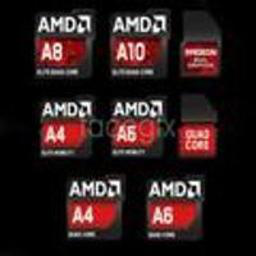

In [ ]:
# Ahora se prueba la función con las imágenes de evaluación:
# Se define la ruta donde se encuentran las imágenes de ADM de evaluación.
path  = "03_evaluation_data/AMD/"
predict_imageIncV3(path + 'AMD (52).jpg',1)

Pizza Hut


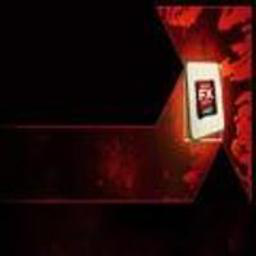

In [ ]:
predict_imageIncV3(path + 'AMD (55).jpg',1)

Aquafina


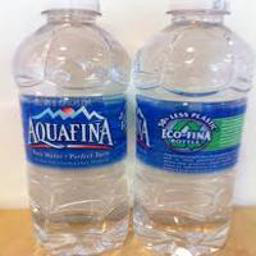

In [ ]:
# Se define la ruta donde se encuentran las imágenes de Aquafina de evaluación.
path  = "03_evaluation_data/Aquafina/"
predict_imageIncV3(path + 'Aquafina (21).jpg',1)

Aquafina


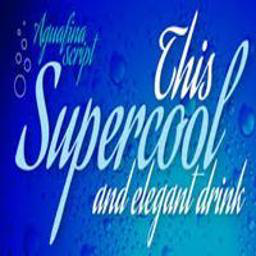

In [ ]:
predict_imageIncV3(path + 'Aquafina (54).jpg',1)

In [ ]:
path  = "03_evaluation_data/"
true_labels_4 = np.array([])
pred_labels_4 = np.array([])

# Se definine un contador de tiempo para validar cuando tarda en evaluar el modelo
tic = time.perf_counter()

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            true_labels_4 = np.append(true_labels_4,dirpath.split('/')[1].strip())
            pred_labels_4 = np.append(pred_labels_4,predict_imageIncV3(new_path,0))

# Se define el contador una vez termina de evaluar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo la evaluación
print(f"\nEvaluar el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")


Evaluar el modelo tarda alrededor de: 1.0870 minutos


In [ ]:
# Evaluación del modelo MobileNet, incluyendo:
#    Reporte de desempeño
#    Reporte de clasificación del modelo
#    Reporte de matriz de confusión
display_model_performance_metrics(true_labels=true_labels_4, 
                                  predicted_labels=pred_labels_4, 
                                  classes=list(set(true_labels_4)))

Model Performance metrics:
------------------------------
Accuracy: 0.7623
Precision: 0.7776
Recall: 0.7623
F1 Score: 0.7624

Model Classification report:
------------------------------
                precision    recall  f1-score   support

         Milka       0.44      0.47      0.45        15
       samsung       0.75      0.60      0.67        15
        Kitkat       0.92      0.73      0.81        15
        Disney       0.83      0.67      0.74        15
            LG       0.83      1.00      0.91        15
      Heineken       0.67      0.40      0.50        15
       Tic Tac       1.00      0.80      0.89        15
      Aquafina       0.71      0.80      0.75        15
     McDonalds       0.73      0.73      0.73        15
     Universal       0.60      0.80      0.69        15
        Nestea       1.00      0.93      0.97        15
        Lipton       0.71      0.80      0.75        15
          sony       0.79      0.73      0.76        15
    Hellmann's       0.93    

Realizando la <font color=green>__EVALUACIÓN__</font> para este modelo <font color=red>__InceptionV3__</font> con las imágenes dedicadas, se evidencia un __*accuracy*__ del __76,23%__ y un __*F-Score*__ del __76,24%__. Las clase que mejor de predijeron fueron Domino's Pizza con el un __*F-Score*__ de __100%__ y Nestea con __97%__; mientras que Milka tiene __45%__ y Heineken el __50%__.

In [ ]:
# Se guarda el modelo
modelIncV3.save('InceptionV3.h5')

## Modelo 5: __ResNet50__

### Construcción del modelo:

Se va a constuir un modelo preentrenado con la red  *__ResNet50__*.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Se define el modelo BASE
input=Input(shape=(256,256,3))
base_modelRN = resnet50.ResNet50(weights = 'imagenet', include_top = False,input_shape = (256,256,3))
output = base_modelRN(input)
# La API funcional de Keras
rn = base_modelRN.output
# Se agrega una capa AveragePooling
rn = GlobalAveragePooling2D()(rn)
# Se agrega una capa densa con 512 y activado con RELU
rn = Dense(512, activation='relu', name='fc-1')(rn)
# Se agrega una capa Dropout para desactivar un numero de neuronas de forma aleatoria
rn = Dropout(0.3)(rn)
# Se agrega una capa densa con 512 y activado con RELU
rn = Dense(512, activation='relu', name='fc-2')(rn)
# Se agrega una capa Dropout para desactivar un numero de neuronas de forma aleatoria
rn = Dropout(0.3)(rn)
# Por último, se agrega una capa densa con el número de categorias que queremos predecir, en ese caso 23.
predsRN = Dense(23, activation='softmax', name='output_layer')(rn)



94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Se define el modelo con el input el modelo base y su respectivo ouput con preds:
modelRN = Model(inputs = base_modelRN.input, outputs = predsRN)
# Se imprime el resumen del modelo
modelRN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Se cuenta cuantas capas tiene mi modelo base:
print("Las capas que tiene mi 'modelo base' son: " + str(len(base_modelRN.layers)) + "\n")

# Se cuenta cuantas capas tiene el modelo:
print("Las capas que tiene mi 'modelo' son: " + str(len(modelRN.layers)))

Las capas que tiene mi 'modelo base' son: 175

Las capas que tiene mi 'modelo' son: 181


In [ ]:
# Se 'congela' las capas del modelo de la siguiente manera:
for layer in modelRN.layers[:-15]:
    layer.trainable = False

modelRN.layers[-15].trainable

True

In [ ]:
# Se define ImageDataGenerator
image_datagenRN = ImageDataGenerator(preprocessing_function = preprocess_resNet50)

# Se define el train_generator tomando los datos desde un directorio (flow_from_directory)
# y con sus respectivos parametros, tamaño, tipo de color, ect...
train_generatorRN = image_datagenRN.flow_from_directory(train_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

#Se define el validation_generator.
validation_generatorRN = image_datagenRN.flow_from_directory(valid_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

# Se define el evaluation_generator.
evaluation_generatorRN = image_datagenRN.flow_from_directory(evalu_dir,
                                                  target_size = (256,256), 
                                                  color_mode = 'rgb',
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  subset = "training")

Found 920 images belonging to 23 classes.
Found 345 images belonging to 23 classes.
Found 345 images belonging to 23 classes.


In [ ]:
print("Lo anterior quiere decir que vamos a entrenar nuestro modelo con: \n"
      + "Datos: " + str(train_generatorRN.subset) 
      + "\nImagenes: " + str(len(train_generatorRN.filepaths)) 
      + "\nClases: " + str(train_generatorRN.num_classes))

print("\nDatos: " + str(validation_generatorRN.subset) 
      + "\nImagenes: " + str(len(validation_generatorRN.filepaths)) 
      + "\nClases: " + str(validation_generatorRN.num_classes))

print("\nDatos: " + str(evaluation_generatorRN.subset) 
      + "\nImagenes: " + str(len(evaluation_generatorRN.filepaths)) 
      + "\nClases: " + str(evaluation_generatorRN.num_classes))

Lo anterior quiere decir que vamos a entrenar nuestro modelo con: 
Datos: training
Imagenes: 920
Clases: 23

Datos: training
Imagenes: 345
Clases: 23

Datos: training
Imagenes: 345
Clases: 23


### Entrenamiento del modelo:

In [ ]:
# Se complila el modelo
modelRN.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Se realiza el cálculo del número total de pasos
step_size_trainRN = (train_generatorRN.n // train_generatorRN.batch_size)

# Se definine un contador de tiempo para validar cuando tarda en entrenar el modelo
tic = time.perf_counter()

# Se entrena el modelo
history_5 = modelRN.fit_generator(generator = train_generatorRN, 
                          steps_per_epoch = step_size_trainRN,
                          epochs = 20, 
                          validation_data = validation_generatorRN)

# Se define el contador una vez termina de entrenar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo el modelo
print(f"\nEntrenando el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
28/28 [==============================] - 273s 10s/step - loss: 2.0882 - accuracy: 0.4178 - mse: 0.0302 - val_loss: 1.1478 - val_accuracy: 0.6783 - val_mse: 0.0188
Epoch 2/20
28/28 [==============================] - 267s 10s/step - loss: 0.6400 - accuracy: 0.8243 - mse: 0.0113 - val_loss: 1.2327 - val_accuracy: 0.7420 - val_mse: 0.0166
Epoch 3/20
28/28 [==============================] - 267s 10s/step - loss: 0.2747 - accuracy: 0.9234 - mse: 0.0049 - val_loss: 0.7572 - val_accuracy: 0.8406 - val_mse: 0.0108
Epoch 4/20
28/28 [==============================] - 269s 10s/step - loss: 0.1614 - accuracy: 0.9505 - mse: 0.0031 - val_loss: 1.0267 - val_accuracy: 0.7971 - val_mse: 0.0130
Epoch 5/20
28/28 [==============================] - 270s 10s/step - loss: 0.0978 - accuracy: 0.9741 - mse: 0.0018 - val_loss: 0.8671 - val_accuracy: 0.8348 - val_mse: 0.0114
Epoch 6/20
28/28 [==============================] - 269s 10s/step - loss: 0.0938 - accuracy: 0.9775 - mse: 0.0017 - val_loss: 0.69

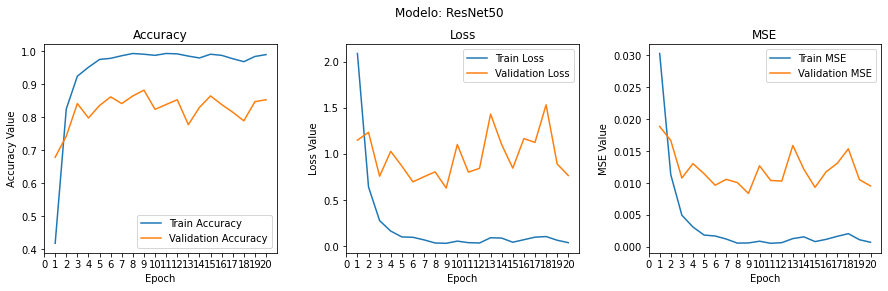

In [ ]:
# Definición para graficar resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
t = f.suptitle('Modelo: ResNet50', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history_5.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history_5.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_5.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_5.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, history_5.history['mse'], label='Train MSE')
ax3.plot(epoch_list, history_5.history['val_mse'], label='Validation MSE')
ax3.set_xticks(np.arange(0, 21, 1))
ax3.set_ylabel('MSE Value')
ax3.set_xlabel('Epoch')
ax3.set_title('MSE')
l3 = ax3.legend(loc="best")

### Evaluación del modelo:

In [ ]:
# Se define el directorio para saber las categorias dentro de 'train_generator'
class_dict = {v:k for k, v in train_generatorRN.class_indices.items()}

# Se define la función para predecir la imagen dando la ruta del archivo
def predict_imageRN(path,retornar):
    img = image.load_img(path)#se carga la imagen.
    img = img.resize((256, 256))#tamaño de la imagen, por temas de memoria y quepa bien puesta.
    data = expand_dims(image.img_to_array(img), 0)#añadimos un 4Tensor.
    data = preprocess_resNet50(data)#realizamos el preprocesado para ResNet50.
    preds = modelRN.predict(data)#modelado Inception V3 definido anteriormente.
    pred = np.argmax(preds)#predicción de la imagen con la ultima capa 'preds'.
    pred = class_dict[pred]#categoria a la que pertenece.
    if retornar:
        print(pred)#impimir la categoria
        return img #retorna la imagen de la ruta enviada como parametro.
    else:
        return pred

AMD


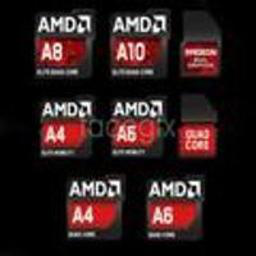

In [ ]:
# Ahora se prueba la función con las imágenes de evaluación:
# Se define la ruta donde se encuentran las imágenes de ADM de evaluación.
path  = "03_evaluation_data/AMD/"
predict_imageRN(path + 'AMD (52).jpg',1)

AMD


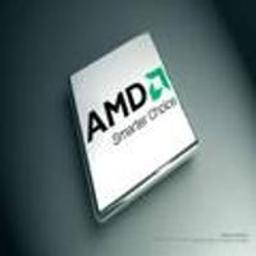

In [ ]:
predict_imageRN(path + 'AMD (54).jpg',1)

Aquafina


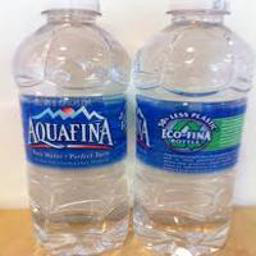

In [ ]:
# Se define la ruta donde se encuentran las imágenes de Aquafina de evaluación.
path  = "03_evaluation_data/Aquafina/"
predict_imageRN(path + 'Aquafina (21).jpg',1)

Aquafina


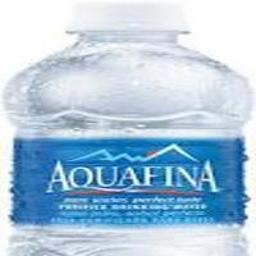

In [ ]:
predict_imageRN(path + 'Aquafina (55).jpg',1)

In [ ]:
path  = "03_evaluation_data/"
true_labels_5 = np.array([])
pred_labels_5 = np.array([])

# Se definine un contador de tiempo para validar cuando tarda en evaluar el modelo
tic = time.perf_counter()

for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            true_labels_5 = np.append(true_labels_5,dirpath.split('/')[1].strip())
            pred_labels_5 = np.append(pred_labels_5,predict_imageRN(new_path,0))

# Se define el contador una vez termina de evaluar el modelo
toc = time.perf_counter()

# Se imprime lo que tardo la evaluación
print(f"\nEvaluar el modelo tarda alrededor de: {((toc - tic)/60):0.4f} minutos")


Evaluar el modelo tarda alrededor de: 1.5671 minutos


In [ ]:
# Evaluación del modelo MobileNet, incluyendo:
#    Reporte de desempeño
#    Reporte de clasificación del modelo
#    Reporte de matriz de confusión
display_model_performance_metrics(true_labels=true_labels_5, 
                                  predicted_labels=pred_labels_5, 
                                  classes=list(set(true_labels_5)))

Model Performance metrics:
------------------------------
Accuracy: 0.8319
Precision: 0.8517
Recall: 0.8319
F1 Score: 0.8311

Model Classification report:
------------------------------
                precision    recall  f1-score   support

     McDonalds       0.80      0.53      0.64        15
            LG       0.82      0.93      0.87        15
        Kitkat       0.88      1.00      0.94        15
      Heineken       0.92      0.73      0.81        15
         Pepsi       0.93      0.87      0.90        15
    Hellmann's       1.00      0.87      0.93        15
           AMD       0.74      0.93      0.82        15
     Pizza Hut       1.00      0.73      0.85        15
       samsung       0.82      0.60      0.69        15
        Nestea       0.72      0.87      0.79        15
         Milka       0.88      0.93      0.90        15
      Aquafina       0.72      0.87      0.79        15
        D-link       1.00      1.00      1.00        15
     Universal       0.74    

Realizando la <font color=green>__EVALUACIÓN__</font> para este modelo <font color=red>__ResNet50__</font> con las imágenes dedicadas, se evidencia un __*accuracy*__ del __83,19%__ y un __*F-Score*__ del __83,11%__. Las clase que mejor de predijeron fueron Domino's Pizza con el un __*F-Score*__ de __100%__ y D-Link con __100%__; mientras que McDonalds tiene __64%__ y Pac-Man el __65%__.

In [ ]:
# Se guarda el modelo
modelRN.save('ResNet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
